<a href="https://colab.research.google.com/github/yamilart/streamlit-dogbreed/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐾 Who let the dogs out? 🐾

Final Project: Dog breed detection

A little info:

*   The original [dataset](https://www.kaggle.com/c/dog-breed-identification/overview) consist in 2 folders with over 20000 images of dogs and a csv with 120 breeds. 
*   I edited the dataset a bit (since there where no dachshunds and dachshunds = 💗) and also only worked with the images in the "train" folder
*   Because of time and resources, this model uses only 20 breeds.

## Packages

In [1]:
import os
import cv2
import datetime
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from numpy import save
import pandas as pd
from tqdm import tqdm
from PIL import Image
from random import randrange
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from IPython.display import display, Image  
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from matplotlib.pyplot import imread
import PIL.Image
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras import applications
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.activations import relu, softmax
from google.colab import drive
from google.colab.patches import cv2_imshow

## Getting Data & EDA

In [2]:
# loading & checking data: breeds
drive.mount('/content/drive') # this is to open files from my drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# loading & checking data: breeds
dogs = pd.read_csv('/content/drive/MyDrive/dog-breeds/labelsbreeds.csv') 
# personal note: paths are going to be different on my computer
dogs

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [12]:
dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [13]:
dogs.shape

(10222, 2)

In [14]:
dogs['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

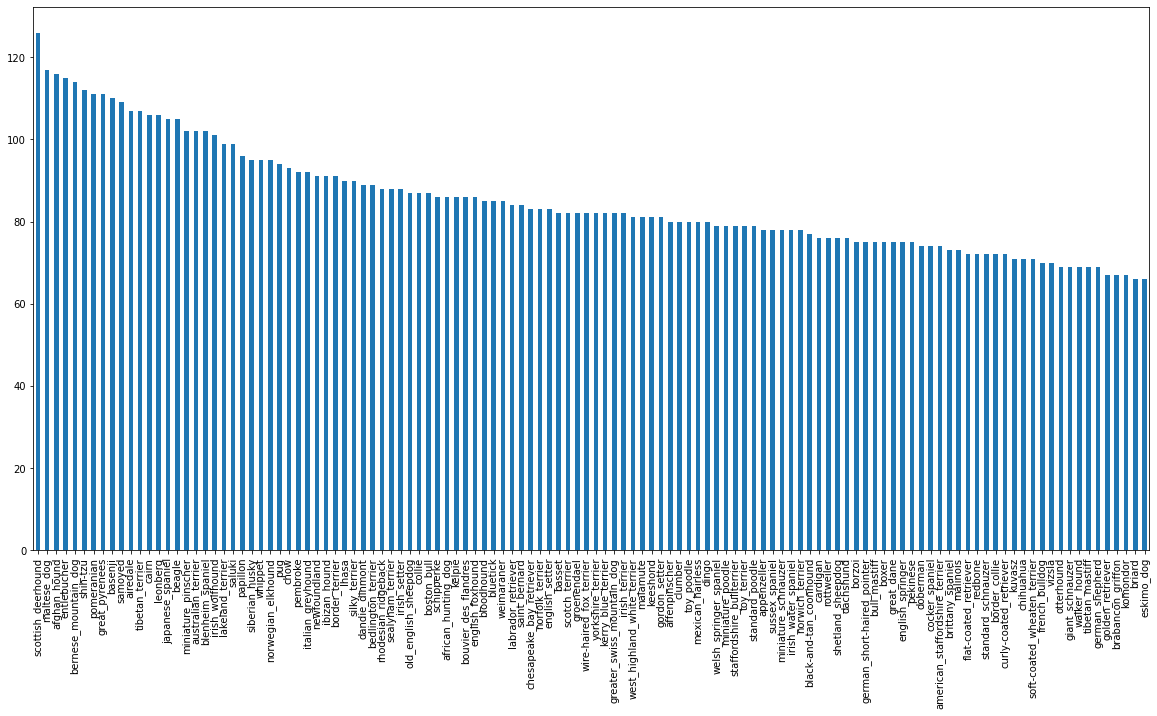

In [15]:
# visualizing the amount of pictures of each breed
dogs['breed'].value_counts().plot.bar(figsize=(20, 10));

In [16]:
# checking the breeds
dogs['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dachshund', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'b

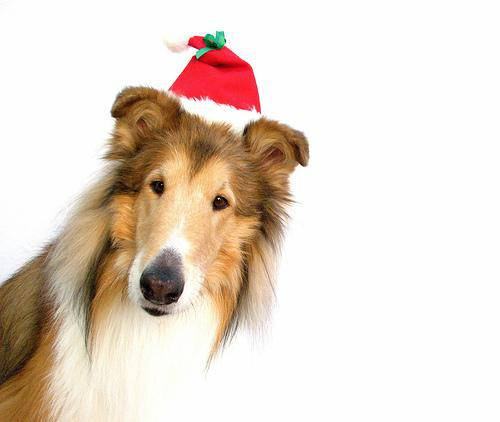

In [17]:
# naming the picture folder
images = '/content/drive/MyDrive/dog-breeds/trainbreeds/'
# checking a random picture
Image('/content/drive/MyDrive/dog-breeds/trainbreeds/0a6c192b96e55e2ca37318919b1ffae6.jpg')

A festive cutie!

In [18]:
# making a copy of the data just in case
somedogs = dogs.copy()

## Selecting data

Since 120 breeds is **A LOT OF DATA TO WORK WITH** I'm going to be realistic and will choose only 20 breeds to start.  
The selection is based on breeds I can recognize and also look quite different to see if this helps the model (or not)

In [19]:
# breed selection: 
breedselection = ['dachshund', 'golden_retriever', 'chow', 'siberian_husky', 
                                                'great_dane', 'french_bulldog', 'rottweiler', 'cocker_spaniel', 
                                                'pekinese', 'doberman', 'boxer', 'labrador_retriever', 
                                                'samoyed', 'beagle', 'chihuahua', 'toy_terrier', 
                                                'weimaraner', 'collie', 'bloodhound', 'yorkshire_terrier']
somedogs = somedogs.loc[somedogs['breed'].isin(breedselection)]
somedogs.reset_index(drop = True, inplace = True)
somedogs.head()

,id,breed
0,001cdf01b096e06d78e9e5112d419397,pekinese
1,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
2,008887054b18ba3c7601792b6a453cc3,boxer
3,008b1271ed1addaccf93783b39deab45,doberman
4,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever


In [20]:
somedogs.shape

(1637, 2)

In [21]:
somedogs['breed'].value_counts()

samoyed               109
beagle                105
siberian_husky         95
chow                   93
collie                 87
weimaraner             85
bloodhound             85
labrador_retriever     84
yorkshire_terrier      82
toy_terrier            79
rottweiler             76
dachshund              76
great_dane             75
boxer                  75
pekinese               75
doberman               74
cocker_spaniel         74
chihuahua              71
french_bulldog         70
golden_retriever       67
Name: breed, dtype: int64

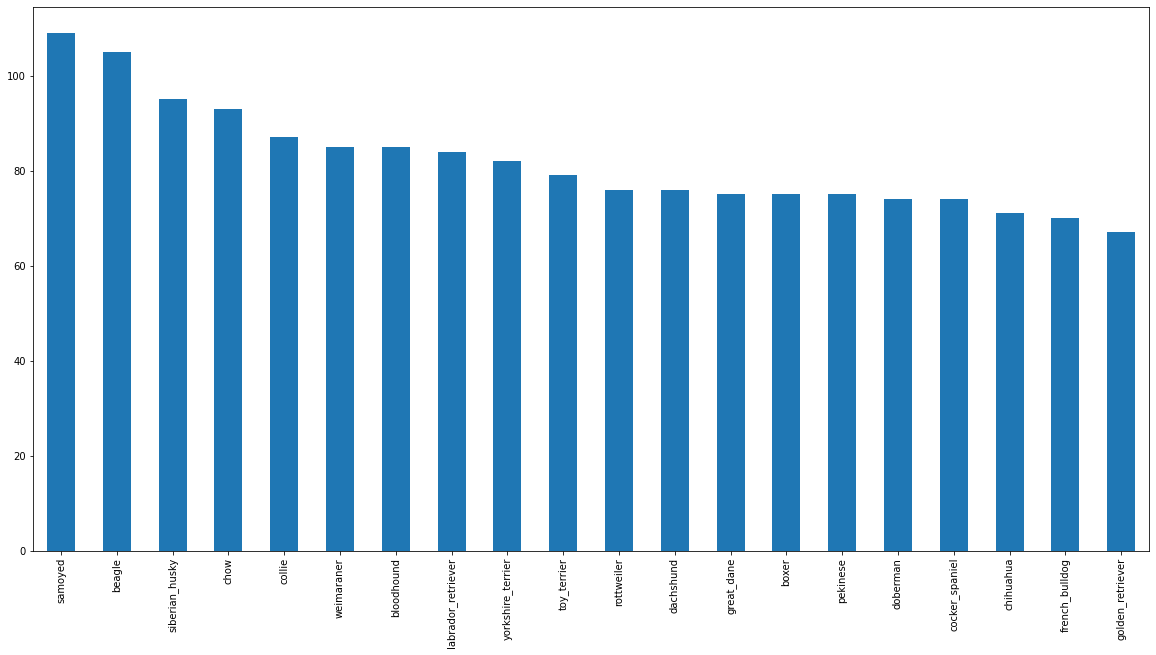

In [22]:
# the amount of pictures of each breed: the graph way
somedogs['breed'].value_counts().plot.bar(figsize=(20, 10));

## Transforming data
I need to transform the data in order to work with it since I basically have images and a bunch of text.

### Images
I need to resize my images (going to use 224 x 224), add a color layer (RGB: 3), turn the images into arrays and scale that array from -1 to 1.

In [23]:
# append each image and breed to a list
dog_pictures = []
dog_breeds = []

for index, x in tqdm(somedogs.iterrows()):
    image = cv2.imread(images + x['id'] + '.jpg')
    image = cv2.resize(image, (224, 224)) # 224 x 224 is a good size for resizing and working with images
    dog_pictures.append(image)
    dog_breeds.append(x['breed'])

1637it [06:27,  4.23it/s]


In [29]:
# turning images to arrays
dog_pics = np.array(dog_pictures)
dog_pics.shape

(1637, 224, 224, 3)
(1637, 20)


### Breeds
Turning the breeds into arrays
 

In [27]:
# turning breeds (labels) into numbers
labenc = LabelEncoder()
dog_b = labenc.fit_transform(dog_breeds)
dog_breed = to_categorical(dog_b)
dog_breed.shape

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Variables X & y

In [30]:
X = dog_pics
y = dog_breed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [32]:
# Checking the size of train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1145, 224, 224, 3), (492, 224, 224, 3), (1145, 20), (492, 20))

In [35]:
amountbreeds = y_test.shape[1]
amountbreeds

20

## The Model
I'll be working with the Keras [Sequencial model](https://keras.io/guides/sequential_model/) only, using a pre-trainde ResNet50 layer.
Since it's a linear stack of layers it's was easier for me to understand it and apply it knowing what I was doing.

To see my huge display of failed attempts you can find the folder called 'how-about-no' where I stored all my notebooks with the different models and processes I learned and follow to develop this final project


In [41]:
# load model
model = Sequential()

# Adding Resnet50 with pretrained imagenet weights
model.add(ResNet50(weights='imagenet', pooling=max, include_top=False, input_shape = (224, 224, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(20, activation = 'softmax')) # number always has to match the amount of breeds
# not train first layer  since it's the pretrained one
model.layers[0].trainable = False

In [42]:
model.compile(optimizer = 'sgd',  loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                40980     
                                                                 
Total params: 23,628,692
Trainable params: 40,980
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
# training and adding a stop for when the value accuracy stops improving
# note: patience is the tolerance
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 3)
history = model.fit(X_train, y_train, epochs = 25, batch_size = 32, validation_split = 0.3, callbacks = early_stop)

Epoch 1/25
26/26 [==============================] - 167s 6s/step - loss: 0.1931 - accuracy: 0.9576 - val_loss: 0.5987 - val_accuracy: 0.8081
Epoch 2/25
26/26 [==============================] - 167s 6s/step - loss: 0.1769 - accuracy: 0.9663 - val_loss: 0.4191 - val_accuracy: 0.8547
Epoch 3/25
26/26 [==============================] - 167s 6s/step - loss: 0.1508 - accuracy: 0.9650 - val_loss: 0.4887 - val_accuracy: 0.8547
Epoch 4/25
26/26 [==============================] - 167s 6s/step - loss: 0.1421 - accuracy: 0.9763 - val_loss: 0.4256 - val_accuracy: 0.8401
Epoch 5/25
26/26 [==============================] - 167s 6s/step - loss: 0.1398 - accuracy: 0.9763 - val_loss: 0.4571 - val_accuracy: 0.8517


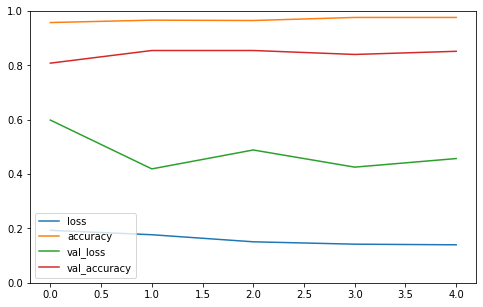

In [45]:
pd.DataFrame(history.history).plot(figsize = (8,5))
pyplot.grid = (True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

### Quick accuracy check

In [46]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print('Accuracy on test: ', round((score[1]*100), 2), '%')

16/16 [==============================] - 71s 4s/step - loss: 0.5719 - accuracy: 0.8374
Accuracy on test:  83.74 %


### Testing the model

In [66]:
def breed_predictor(image_file):
    image = cv2.imread(image_file)
    image = cv2.resize(image, (224, 224))
    # dog_img = Image.open(image_file)
    image = image.reshape(1,224,224,3)
    result_prob = model.predict(image)
    result = result_prob.argmax(axis=-1)
    result = labenc.inverse_transform(result)
    return print("I'm " + str(round(np.amax(result_prob)*100,2)) + ' sure this cute dog is a ' + result[0])

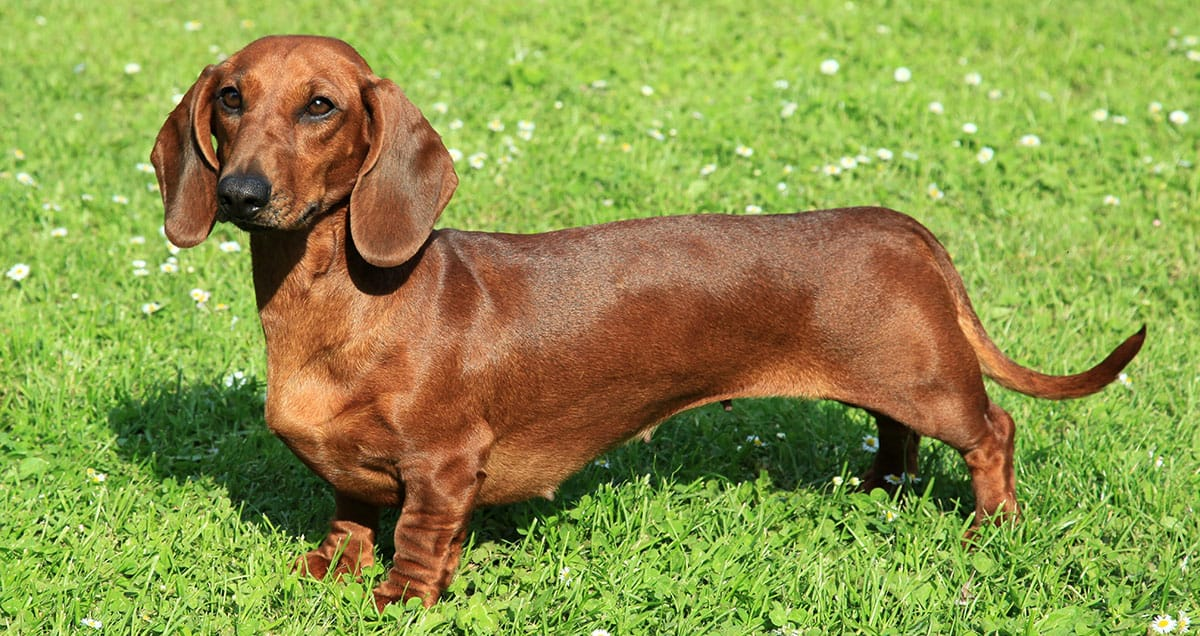

In [64]:
# trying a random picture
Image('/content/drive/MyDrive/dog-breeds/dachshund.jpg')

In [67]:
file_n = '/content/drive/MyDrive/dog-breeds/dachshund.jpg'
breed_predictor(file_n)

I'm 98.85 sure this cute dog is a dachshund


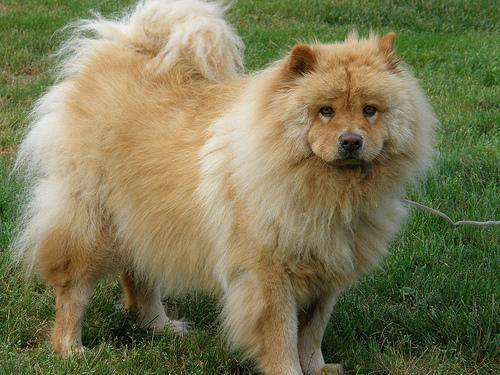

In [58]:
# trying a picture from the dataset
Image('/content/drive/MyDrive/dog-breeds/trainbreeds/0c207c7af2d1ef71dc61434f04d00cdf.jpg')

In [68]:
file_n = '/content/drive/MyDrive/dog-breeds/trainbreeds/0c207c7af2d1ef71dc61434f04d00cdf.jpg'
breed_predictor(file_n)

I'm 96.42 sure this cute dog is a chow


YAY!

### Saving the model

In [53]:
def save_model(model, suffix=None):
  modeldir = os.path.join("/content/drive/My Drive/dog-breeds/")
  model_path = modeldir + "-" + suffix + ".h5" 
  model.save(model_path)
  return model_path

In [54]:
def load_model(model_path):
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [70]:
save_model(model, suffix="20-breeds")

'/content/drive/My Drive/dog-breeds/-20-breeds.h5'